<a href="https://colab.research.google.com/github/eridanletalis/gb_databases/blob/main/mysql_hw_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2>Урок 4. SQL – работа с несколькими таблицами</h2>

Условие:
1. Подсчитать общее количество лайков, которые получили пользователи
младше 12 лет.



<code>
SELECT COUNT(*) likes_cnt<br />
FROM likes lk<br />
JOIN media md ON lk.media_id = md.id -- Кто какому медиа поставил лайк<br />
JOIN profiles pf ON pf.user_id = md.user_id -- Кому принадлежит это медиа<br />
WHERE pf.birthday > DATE_ADD(SYSDATE(), INTERVAL -12 YEAR);<br />
</code>

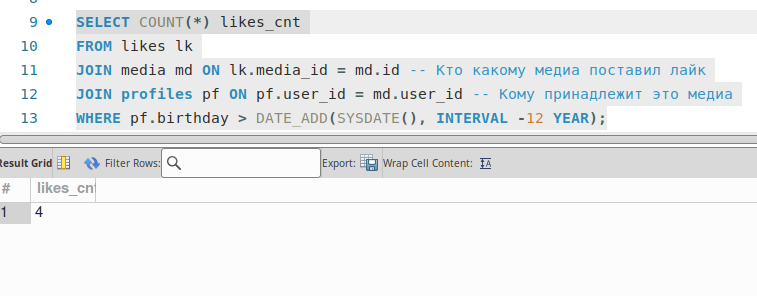

2. Определить кто больше поставил лайков (всего): мужчины или
женщины.


</code>
WITH f_cnt AS (<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;SELECT  SQL_SMALL_RESULT COUNT(*) cnt<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;FROM profiles pf<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;JOIN likes lk_f on pf.user_id = lk_f.user_id AND pf.gender = 'f'),<br />
m_cnt AS (<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;SELECT  SQL_SMALL_RESULT COUNT(*) cnt<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;FROM profiles pf<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;JOIN likes lk_f on pf.user_id = lk_f.user_id AND pf.gender = 'm')<br />
<br />
SELECT CASE<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;WHEN (SELECT cnt FROM f_cnt) > (SELECT cnt FROM m_cnt) <br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;THEN 'Лайков от женщин больше'<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;WHEN (SELECT cnt FROM f_cnt) < (SELECT cnt FROM m_cnt) <br />
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;THEN 'Лайков от мужчин больше'<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ELSE 'Число лайков равно'<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;END who_is_winner<br />
FROM DUAL; <br />
</code>

SQL_SMALL_RESULT - Попытка сообщить оптимизатору, что запрос будет давать маленькое число строк на выходе. Не уверен, что так можно оптимизировать и кэшировать результаты, чтобы то, что в WITH ... AS вычислялось по одному разу, а не при каждом вызове. 

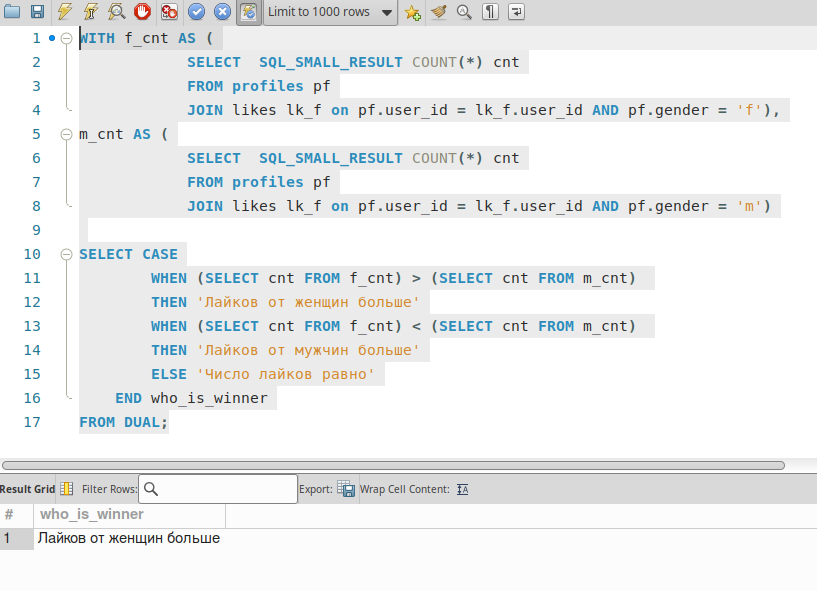

3. Вывести всех пользователей, которые не отправляли сообщения.


Вариант 1

<code>
SELECT pf.user_id <br />
FROM profiles pf <br />
WHERE user_id NOT IN (<br />
SELECT from_user_id<br />
FROM messages);<br />
</code>

Вариант 2
<code>
SELECT pf.user_id<br />
FROM profiles pf<br />
LEFT JOIN messages ms ON pf.user_id = ms.from_user_id<br />
WHERE ms.id IS NULL;<br />
</code>

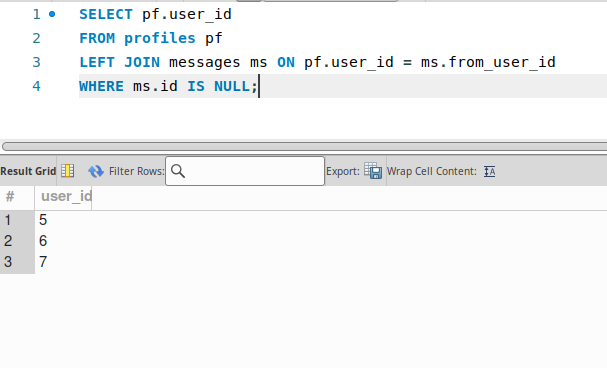

4. (по желанию)* Пусть задан некоторый пользователь. Из всех друзей
этого пользователя найдите человека, который больше всех написал
ему сообщений.

Общая часть решения представлена ниже.
Здесь требуется уточнить условия:
1. Будет ли пользователь задан вручную, либо переменной?
2. Что делать, если число сообщений одинаковое?

<code>
SELECT 	fin.to_user, <br />
&nbsp;&nbsp;&nbsp;&nbsp;fin.from_user<br />
FROM (<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;SELECT cnts.to_user to_user, <br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;cnts.from_user from_user,<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;cnts.cnt cnt,<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;MAX(cnts.cnt) OVER (PARTITION BY cnts.to_user) max_cnt<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;FROM (<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;SELECT ms.to_user_id to_user, <br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ms.from_user_id from_user, <br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;COUNT(*) cnt<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;FROM messages ms<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;GROUP BY ms.to_user_id, ms.from_user_id<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;) cnts<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;) fin<br />
WHERE fin.cnt = fin.max_cnt;
</code>

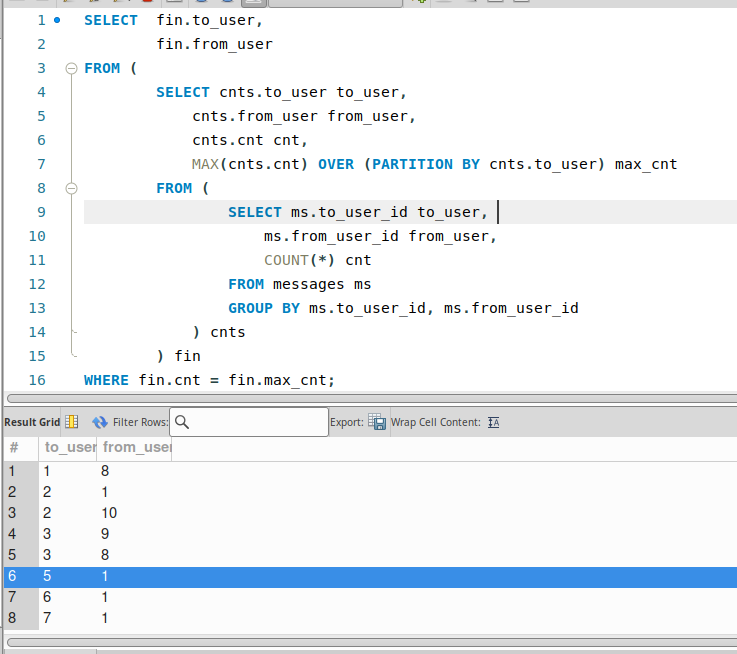

Например, если принимается решение, что id пользователя задаётся переменной, а вывести надо любого из "максимальных", то можно "втроить" во внутренний запрос фильстр по user_id, задать SELECT @user_id := 1; забрать WHERE to_user_id = @user_id. А для фильтра вывода использовать LIMIT 1.